In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random

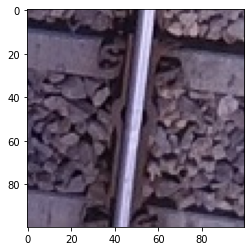

In [2]:
test_img_loc = 'C:/Users/hp/Desktop/Mod1-IITR/fishplate/pos/40.jpg'
feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
plt.imshow(feature_image)
plt.show()

In [82]:
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [200, 400] # Min and max in y to search in slide_window()

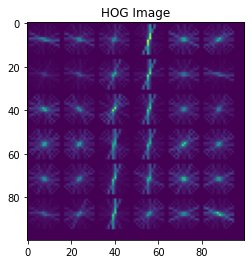

In [83]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
hog_features, hog_image = get_hog_features(feature_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.imshow(hog_image)
plt.title('HOG Image')
plt.show()

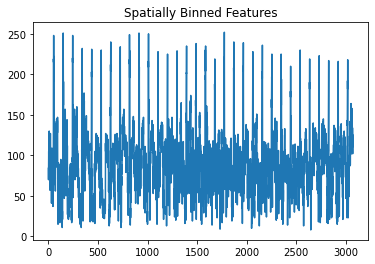

In [84]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Plot features
feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
feature_vec = bin_spatial(feature_image, size=spatial_size)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()

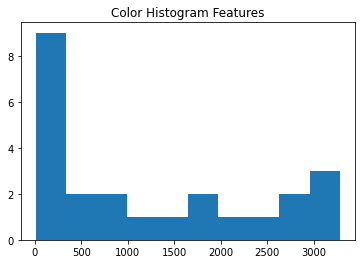

In [85]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
hist_features = color_hist(feature_image, nbins=hist_bins)
plt.hist(hist_features)
plt.title('Color Histogram Features')
plt.show()

In [86]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=16, orient=9, 
                        pix_per_cell=16, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, hog_features=None):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if True: #hog_features is None:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img = cv2.imread(file)
        file_features = single_img_features(img, color_space, spatial_size,
            hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
            spatial_feat, hist_feat, hog_feat)
        features.append(file_features)
    # Return list of feature vectors
    return features

In [87]:
def prepare_images_for_processing(car_img_folders, noncar_img_folders, image_type):
    cars = []
    for folder in car_img_folders:
        cars += glob.glob(folder +'/*.' + image_type)
        
    notcars = []
    for folder in noncar_img_folders:
        notcars += glob.glob(folder +'/*.' + image_type)

    print("Cars len: ", len(cars))
    print("Notcars len: ", len(notcars))

    # Keep distribution even
    train_size = 8500
    cars = cars[:train_size]
    notcars = notcars[:train_size]
    
    car_features = extract_features(cars, color_space=color_space, 
        spatial_size=spatial_size, hist_bins=hist_bins, 
        orient=orient, pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, 
        hog_channel=hog_channel, spatial_feat=spatial_feat, 
        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
        spatial_size=spatial_size, hist_bins=hist_bins, 
        orient=orient, pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, 
        hog_channel=hog_channel, spatial_feat=spatial_feat, 
        hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    return scaled_X, y, X_scaler

In [88]:
car_folders = ['C:/Users/hp/Desktop/Mod1-IITR/fishplate/pos']
notcar_folders = ['C:/Users/hp/Desktop/Mod1-IITR/fishplate/neg']
scaled_X, y, X_scaler = prepare_images_for_processing(car_folders, notcar_folders, "jpg")
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 80)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Cars len:  40
Notcars len:  40
Using: 16 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4696
0.02 Seconds to train SVC...
Test Accuracy of SVC =  1.0


In [89]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None]):
    windows_a = slide_window_helper(img, x_start_stop, y_start_stop, window_size=[128, 128])
    windows_b = slide_window_helper(img, x_start_stop, y_start_stop, window_size=[64, 64])
    windows_c = slide_window_helper(img, x_start_stop, y_start_stop, window_size=[32, 32])
    return windows_a + windows_b + windows_c

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window_helper(img, x_start_stop=[None, None], y_start_stop=[None, None], window_size=[96, 64]):
    window_size_x = window_size[0]
    window_size_y = window_size[1]
    xy_overlap=(0.5, 0.5)
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(window_size_x*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(window_size_y*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 2
    ny_windows = np.int(yspan/ny_pix_per_step) - 2
    # Initialize a list to append window positions to
    window_list = []
    
    ys = y_start_stop[0]
    while ys + window_size_y < y_start_stop[1]: 
        xs = x_start_stop[0]
        while xs < x_start_stop[1]:
            # Calculate window position
            endx = xs + window_size_x
            endy = ys + window_size_y

            # Append window position to list
            window_list.append(((xs, ys), (endx, endy)))

            xs += nx_pix_per_step
        window_size_x = int(window_size_x * 1.3)
        window_size_y = int(window_size_y * 1.3)
        nx_pix_per_step = np.int(window_size_x*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(window_size_y*(1 - xy_overlap[1]))
        ys += ny_pix_per_step

    # Return the list of windows
    return window_list

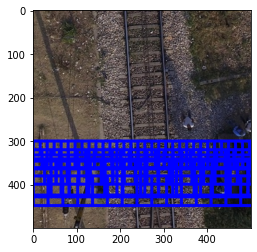

In [90]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

feature_image = cv2.imread('C:/Users/hp/Desktop/Mod1-IITR/test/3.jpg')
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
windows = slide_window(feature_image, x_start_stop=[None, None], y_start_stop=y_start_stop)              
window_img = draw_boxes(feature_image, windows, color=(0, 0, 255), thick=6)  
plt.imshow(window_img)
plt.show()

In [91]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=16, 
                    pix_per_cell=16, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    count = 0
    image_id = random.randint(0, 80)
    for window in windows:
        count += 1
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
#         cv2.imwrite("frames/window%d%d.jpg" % (image_id, count), test_img)
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # Return windows for positive detections
    return on_windows

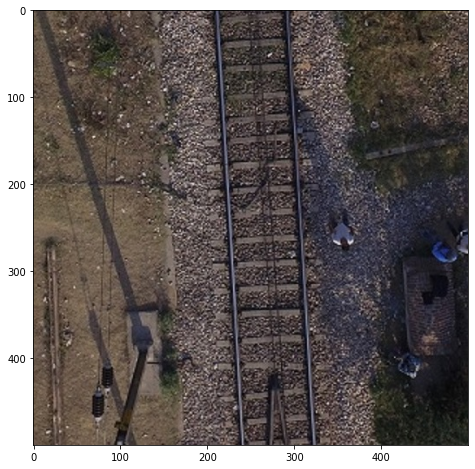

ValueError: X has 3672 features, but this StandardScaler is expecting 4696 features as input.

In [92]:
def label_vehicles(image, X_scaler):
    draw_image = np.copy(image)
    draw_image = cv2.cvtColor(draw_image, cv2.COLOR_RGB2BGR)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop)
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    return window_img

f, axarr = plt.subplots(1, 1, figsize=(8,8))

test_img = 'C:/Users/hp/Desktop/Mod1-IITR/test/3.jpg'
img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

img_with_label = label_vehicles(img, X_scaler)
axarr.imshow(img_with_label)
plt.setp([a.get_xticklabels() for a in axarr[:]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:]], visible=False)
f.subplots_adjust(hspace=0)
plt.show()